# Data Analysis and Processing Notebook 
# Project : Addressing Inequity in Medical Specialist Distribution in Thailand

This notebook serves as a comprehensive guide for processing and analyzing health workforce data. It includes data scraping, cleaning, and analysis

**Objectives:**
- Scrape physicians data from MOPH database http://gishealth.moph.go.th.
- Apply data cleaning techniques.
- Analyse the ratio-to-population and inequity index.
- Visualize the changes along specific period.

**Requirements:**
Ensure the following libraries are installed before running the notebook:
```bash
pip install -r scripts/requirements.txt

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os
import itertools
import warnings
from tqdm import tqdm
from scripts import process
from scripts import analyse
from scripts import scrp_spc
from IPython.display import clear_output

pd.set_option('future.no_silent_downcasting', True)
warnings.simplefilter('ignore', DeprecationWarning)

In [2]:
# Import Thailand hospital data
hosp_file = 'hosp'
data_dir = 'data'
output_dir = 'output/clean'

hosp, hosp_raw, dict_path = process.DataCleaning.clean(hosp_file, data_dir, output_dir, clear=True)
hosp = hosp[(hosp['status'] != 'ยกเลิก')]
hosp['hcode'] = hosp['hcode'].apply(lambda x: x[2:-1]) #convert hcode from ="xxxxx" to xxxxx
hosp = hosp[hosp['type'].isin(['โรงพยาบาลเอกชน', 'โรงพยาบาล นอก สธ.', 'โรงพยาบาล นอก สป.สธ.', 'โรงพยาบาลชุมชน', 'โรงพยาบาลทั่วไป', 'โรงพยาบาลศูนย์'])].copy()
hosp.to_csv('output/clean/hosp_cleaned.csv')

# Hospital descriptive
hosp_total = len(hosp)
hosp_public = len(hosp[hosp['sector']=='รัฐบาล'])
hosp_private = len(hosp[hosp['sector']=='เอกชน'])

print(
      "----------------------------------------------------",
      "\nTotal hospital:" , hosp_total,
      "\nTotal public hospital:", hosp_public,
      "\nTotal private hospital:", hosp_private,
      "\n----------------------------------------------------")

File name                : hosp
Path to data dictionary  : data/data_dict-hosp.xlsx
Path to cleaned dataset  : output/clean/hosp_cleaned.csv
---------------------------------------------------- 
Total hospital: 1560 
Total public hospital: 1101 
Total private hospital: 459 
----------------------------------------------------


In [3]:
# Import Thailand population data
hosp_file = 'pop'
data_dir = 'data/pop'
output_dir = 'output/clean'

years = range(2014,2024)

pop_country = pd.DataFrame()
pop_hregion = pd.DataFrame()
pop_prov = pd.DataFrame()
pop_dist = pd.DataFrame()

for year in years:
    
    hosp_file = f'data/pop/pop_{year}.xlsx'
    pop = pd.read_excel(hosp_file, sheet_name='pop')
    pop = process.DataCleaning.update_column_name(pop, 'data/pop/data_dict-pop.xlsx')

    pop['prov'] = pop['prov'].apply(lambda x: x if x in ['กรุงเทพมหานคร', 'ทั่วประเทศ'] else x[7:])
    pop['year'] = year
    
    country = pop[pop['prov_id'] == 0][['year', 'prov', 'pop']]
    pop_country = pd.concat([pop_country, country], ignore_index=True)
    pop_country.to_csv('output/clean/pop_country.csv')
    
    prov = pop[(pop['prov_id'] != 0) & (pop['dist_id'] == 0) & (pop['subdist_id'] == 0) & (pop['village_id'] == 0)][['year', 'prov', 'prov_id', 'pop']]
    pop_prov = pd.concat([pop_prov, prov], ignore_index=True)
    pop_prov.to_csv('output/clean/pop_prov.csv')

    dist = pop[pop['subdist_id'] != 0][['year', 'subdist_id', 'pop']]
    dist['subdist_id'] = dist['subdist_id'].astype(str)
    dist['subdist_id'] = dist['subdist_id'].apply(lambda x: x[:-4])
    dist.rename(columns=lambda x: x.replace('subdist_id', 'dist_id') if x.startswith('subdist_id') else x, inplace=True)
    dist = dist.groupby(['year', 'dist_id']).sum().reset_index()
    pop_dist = pd.concat([pop_dist, dist], ignore_index=True)
    pop_dist.to_csv('output/clean/pop_dist.csv')

    hregion = prov.copy()
    hregion = process.DataManipulation.mapping(hregion, 'prov')
    hregion.rename(columns=lambda x: x.replace('prov', 'hregion') if x.startswith('prov') else x, inplace=True)
    hregion = hregion.groupby(['year', 'hregion']).sum().reset_index()
    hregion['hregion_id'] = hregion['hregion'].apply(lambda x: x[-2:] if len(x) == 15 else x[-1:])
    pop_hregion = pd.concat([pop_hregion, hregion], ignore_index=True)

clear_output()

In [6]:
scrp = input("Would you like to run the scraping process? (Y/N): ").strip().upper()
output_dir = 'output/scraped'

if scrp == 'Y':

    hosp_id = pd.DataFrame({
        'hosp_id': hosp['hcode']
    })

    spc_link = pd.DataFrame({
        'link': ['infopersonal', 'infospecialty', 'infospecialty2', 'infospecialty3', 'infospecialty4', 'infospecialty5']
    })

    spc_path = scrp_spc.scrap(hosp_id, spc_link, output_dir)
    spc_df = pd.read_csv(spc_path)
    
elif scrp == 'N':
    
    # Use previously saved data
    spc_path = os.path.join(output_dir, 'spc.csv')
    
    if os.path.exists(spc_path):
        spc_df = pd.read_csv(spc_path)
        print(f"Data from '{spc_path}' has been successfully loaded and processed.")
    else:
        print(f"Error: The file '{spc_path}' does not exist. Please run the scraping first.")

spc_df['hosp_id'] = spc_df['hosp_id'].apply(lambda x: f'{x:05}')  # Format hospital ID to 5 digits
spc_df = spc_df[spc_df['time'] != 'ไม่มีการบันทึกข้อมูล']
spc_df['time'] = spc_df['time'].apply(lambda x: x[-4:]).astype(int)
spc_df['time'] = spc_df['time'].apply(lambda x: x-543)


required_years = set(range(2014, 2024))

physicians = spc_df[spc_df['spc'].isin(['แพทย์', 'นายแพทย์'])]
complete_physician = physicians.groupby('hosp_id')['time'].apply(lambda x: set(x) >= required_years)
complete = complete_physician[complete_physician].index.tolist()
incomplete = complete_physician[~complete_physician].index.tolist()
display(f"Number of hospitals with complete data of physicians over 10 years: {len(complete)}")

specialists = spc_df[~spc_df['spc'].isin(['แพทย์', 'นายแพทย์'])]
complete_specialist = specialists.groupby('hosp_id')['time'].apply(lambda x: set(x) >= required_years)
complete = complete_specialist[complete_specialist].index.tolist()
incomplete = complete_specialist[~complete_specialist].index.tolist()
display(f"Number of hospitals with complete data of specialists over 10 years: {len(complete)}")

spc_df['spc'] = spc_df['spc'].apply(lambda x: 'แพทย์' if x == 'นายแพทย์' else x)
spc_df = spc_df.drop_duplicates(subset=['hosp_id', 'spc', 'time', 'total'], keep='first')

spc_df['total'] = spc_df['total'].apply(lambda x: 0 if pd.isna(x) else x)

groups = spc_df.groupby(['hosp_id', 'spc'], as_index=False)
for name, group in tqdm(groups, desc="Processing Groups"):
    modified_group, modified = process.DataManipulation.outlier_loo(group, 'total', 'time', include_columns=['hosp_id', 'spc'], mse_threshold_ratio=0.01, impute='backward', print_outliers=False)
    if modified:
        spc_df.loc[modified_group.index, :] = modified_group

hosp_ids = spc_df['hosp_id'].unique()
spcs = spc_df['spc'].unique()
years = range(spc_df['time'].min(), 2025)
combinations = list(itertools.product(hosp_ids, spcs, years))

full_years = pd.DataFrame(combinations, columns=['hosp_id', 'spc', 'time'])
spc_df = pd.merge(full_years, spc_df, how='left', on=['hosp_id', 'spc', 'time'])
groups = spc_df.groupby(['hosp_id', 'spc'], as_index=False)
spc_df = groups.apply(lambda group: group.ffill()).reset_index(drop=True)

spc_df = spc_df.drop_duplicates(subset=['hosp_id', 'spc', 'time'], keep='last')

process.DataManipulation.mapping(spc_df, 'spc')
spc_df = spc_df.groupby(['hosp_id', 'spc', 'time']).sum().reset_index()

spc_df.rename(columns={'time': 'year'}, inplace=True)

spc_df.to_csv('output/clean/spc_cleaned.csv')

Data from 'output/scraped/spc.csv' has been successfully loaded and processed.


'Number of hospitals with complete data of physicians over 10 years: 18'

'Number of hospitals with complete data of specialists over 10 years: 23'

Processing Groups: 100%|██████████| 148342/148342 [01:24<00:00, 1747.19it/s]


Analyse for overall doctor

In [23]:
df = spc_df.copy()
df = spc_df[(spc_df['year'] >= 2014) & (spc_df['year'] <= 2023)]
df = pd.merge(df, hosp[['hcode', 'prov', 'dist_id', 'hregion', 'type']], how='left', left_on='hosp_id', right_on='hcode')
df['dist_id'] = df['dist_id'].astype(int).astype(str)
df['type_gr'] = df['type'].apply(lambda x: 'private' if x == 'โรงพยาบาลเอกชน' else 'public')

n_hosp = len(spc_df['hosp_id'].unique())
n_hosp_public = len(df[df['type_gr'] == 'public']['hosp_id'].unique())
n_hosp_private = len(df[df['type_gr'] == 'private']['hosp_id'].unique())

print(
      "----------------------------------------------------",
      "\nTotal hospital:" , n_hosp,
      "\nTotal public hospital:", n_hosp_public,
      "\nTotal private hospital:", n_hosp_private,
      "\n----------------------------------------------------")

total_doctor = df.pivot_table(index=['year', 'spc'], values='total', aggfunc='sum', fill_value=0).reset_index()
public_doctor = df[df['type_gr'] == 'public'].pivot_table(index=['year', 'spc'], values='total', aggfunc='sum', fill_value=0).reset_index()

total_doctor = pd.merge(total_doctor, public_doctor, how='left', on=['year', 'spc'], suffixes=('_grand', '_public'))
total_doctor['total_private'] = total_doctor['total_grand'] - total_doctor['total_public']
total_doctor['percentage_public'] = total_doctor.apply(lambda row: f'{((row['total_public']/row['total_grand'])*100):.2f}%', axis=1)

total_doctor = pd.merge(total_doctor, pop_country[['year', 'pop']], how='left', on='year')
total_doctor['ratio'] = total_doctor['total_public']/(total_doctor['pop']/1000)

total_doctor.to_csv('output/analyse/Table 1-Total Doctor and Specialist in country level.csv')

mapping = {'General Practitioner': 'Generalist', 'Physician': 'Physician'}
df['spc_type'] = df['spc'].map(mapping).fillna('Specialist')

hosp_doctor = df[['hosp_id', 'spc_type', 'year', 'total']]
hosp_doctor = hosp_doctor.groupby(['hosp_id', 'year', 'spc_type']).sum().reset_index()
hosp_doctor = hosp_doctor.pivot(index=['hosp_id', 'year'], 
                                      columns='spc_type', 
                                      values='total').fillna(0)
hosp_doctor.to_csv('output/analyse/Table 2-Total Doctor and Specialist in hospital level.csv')

prov_doctor = df[['prov', 'spc_type', 'year', 'total']]
prov_doctor = prov_doctor.groupby(['prov', 'year', 'spc_type']).sum().reset_index()
prov_doctor = prov_doctor.pivot(index=['prov', 'year'], 
                                      columns='spc_type', 
                                      values='total').fillna(0)
prov_doctor['ratio'] = prov_doctor['Generalist'] / prov_doctor['Specialist']
prov_doctor.to_csv('output/analyse/Table 3-Total Doctor and Specialist in provincial level.csv')

---------------------------------------------------- 
Total hospital: 1476 
Total public hospital: 1088 
Total private hospital: 388 
----------------------------------------------------


In [131]:
# Export data for visualization

df = spc_df.copy()
df = pd.merge(df, hosp[['hcode', 'prov', 'dist_id', 'hregion', 'type']], how='left', left_on='hosp_id', right_on='hcode')
df['dist_id'] = df['dist_id'].astype(int).astype(str)
df['type_gr'] = df['type'].apply(lambda x: 'private' if x == 'โรงพยาบาลเอกชน' else 'public')

df_public = df[df['type_gr'] == 'public']

# Region level
df_hregion = df_public.pivot_table(index=['year', 'hregion', 'spc'], values='total', aggfunc='sum', fill_value=0).reset_index()
df_hregion = pd.merge(df_hregion, pop_hregion[['year', 'hregion', 'pop']], how='left', on=['year', 'hregion'])
df_hregion['den'] = df_hregion['total']/(df_hregion['pop']/1000)
df_hregion.to_csv('output/analyse/Table 2-Density in health region.csv')

# Province level
df_prov = df_public.pivot_table(index=['year', 'prov', 'spc'], values='total', aggfunc='sum', fill_value=0).reset_index()
df_prov = pd.merge(df_prov, pop_prov[['year', 'prov', 'pop']], how='left', on=['year', 'prov'])
df_prov['den'] = df_prov['total']/(df_prov['pop']/1000)
df_prov.to_csv('output/analyse/Table 3-Density in prov.csv')

# District level
df_dist = df_public.pivot_table(index=['year', 'dist_id', 'spc'], values='total', aggfunc='sum', fill_value=0).reset_index()
df_dist = pd.merge(df_dist, pop_dist[['year', 'dist_id', 'pop']], how='left', on=['year', 'dist_id'])
df_dist['den'] = df_dist['total']/(df_dist['pop']/1000)
df_dist.to_csv('output/analyse/Table 4-Density in district.csv')

In [132]:
# Create blank dataframe
result_coverage = pd.DataFrame()
result_ineq = pd.DataFrame()

years = range(2014,2024)

for year in years:
    
    df = df_public[df_public['year'] == year]
    
    for spc in sorted(df_public['spc'].unique()):
        row = {}
        row['year'] = year
        row['spc'] = spc

        row['n_spc'] = np.sum(df[df['spc'] == spc]['total'])
        row['cov_hregion'] = analyse.coverage(df_hregion[(df_hregion['year'] == year) & (df_hregion['spc'] == spc)], 'total', 'hregion')
        row['cov_prov'] = analyse.coverage(df_prov[(df_prov['year'] == year) & (df_prov['spc'] == spc)], 'total', 'prov')
        row['cov_dist'] = analyse.coverage(df_dist[(df_dist['year'] == year) & (df_dist['spc'] == spc)], 'total', 'dist')

        result_coverage = pd.concat([result_coverage, pd.DataFrame([row])], ignore_index=True)

result_coverage.to_csv('output/analyse/result_coverage.csv')
display("Coverage analysis", result_coverage)


for year in years:
    
    df = df_public[df_public['year'] == year]
    
    for spc in sorted(df_public['spc'].unique()):
        row = {}
        row['year'] = year
        row['spc'] = spc

        row['n_spc'] = np.sum(df[df['spc'] == spc]['total'])
        row['T_hregion'] = analyse.theil_T(df_hregion[(df_hregion['year'] == year) & (df_hregion['spc'] == spc)], h_column='total', pop_column='pop')
        row['G_hregion'] = analyse.gini(df_hregion[(df_hregion['year'] == year) & (df_hregion['spc'] == spc)], h_column='total', pop_column='pop')
        row['T_prov'] = analyse.theil_T(df_prov[(df_prov['year'] == year) & (df_prov['spc'] == spc)], h_column='total', pop_column='pop')
        row['G_prov'] = analyse.gini(df_prov[(df_prov['year'] == year) & (df_prov['spc'] == spc)], h_column='total', pop_column='pop')
        row['T_dist'] = analyse.theil_T(df_dist[(df_dist['year'] == year) & (df_dist['spc'] == spc)], h_column='total', pop_column='pop')
        row['G_dist'] = analyse.gini(df_dist[(df_dist['year'] == year) & (df_dist['spc'] == spc)], h_column='total', pop_column='pop')

        result_ineq = pd.concat([result_ineq, pd.DataFrame([row])], ignore_index=True)

result_ineq.to_csv('output/analyse/result_ineq.csv')
display("Inequity analysis", result_ineq)

'Coverage analysis'

,year,spc,n_spc,cov_hregion,cov_prov,cov_dist
0,2014,Anesthesiology,767.0,13 (100.00%),75 (97.40%),156 (16.81%)
1,2014,Emergency Medicine,162.0,13 (100.00%),50 (64.94%),63 (6.79%)
2,2014,Family Medicine,657.0,13 (100.00%),71 (92.21%),271 (29.20%)
3,2014,General Practitioner,1652.0,13 (100.00%),74 (96.10%),375 (40.41%)
4,2014,Gynecology,1269.0,13 (100.00%),77 (100.00%),267 (28.77%)
...,...,...,...,...,...,...
175,2023,Preventive Medicine,540.0,13 (100.00%),71 (92.21%),281 (30.28%)
176,2023,Psychiatry,766.0,13 (100.00%),76 (98.70%),148 (15.95%)
177,2023,Radiology,1364.0,13 (100.00%),77 (100.00%),208 (22.41%)
178,2023,Rehabilitation Medicine,453.0,13 (100.00%),72 (93.51%),138 (14.87%)


'Inequity analysis'

,year,spc,n_spc,T_hregion,G_hregion,T_prov,G_prov,T_dist,G_dist
0,2014,Anesthesiology,767.0,0.236174,0.347969,0.362592,0.462707,1.811081,0.836181
1,2014,Emergency Medicine,162.0,0.225618,0.366765,0.645172,0.558243,2.313889,0.913351
2,2014,Family Medicine,657.0,0.058892,0.187505,0.193797,0.340678,1.245328,0.752076
3,2014,General Practitioner,1652.0,0.048508,0.141473,0.203749,0.348404,1.046958,0.727875
4,2014,Gynecology,1269.0,0.106033,0.228294,0.172010,0.321461,1.196913,0.739797
...,...,...,...,...,...,...,...,...,...
175,2023,Preventive Medicine,540.0,0.031976,0.133423,0.166623,0.309576,1.105103,0.734642
176,2023,Psychiatry,766.0,0.190399,0.319993,0.297585,0.419587,1.700200,0.830483
177,2023,Radiology,1364.0,0.230603,0.303821,0.320829,0.424985,1.653750,0.808803
178,2023,Rehabilitation Medicine,453.0,0.147662,0.283024,0.257481,0.393938,1.487776,0.803346


In [ ]:
for year in years:
    
    df = df_public[df_public['year'] == year]
    
    for spc in sorted(df_public['spc'].unique()):
        row = {}
        row['year'] = year
        row['spc'] = spc

        row['n_spc'] = np.sum(df[df['spc'] == spc]['total'])
        row['T_hregion'] = analyse.theil_T(df_hregion[(df_hregion['year'] == year) & (df_hregion['spc'] == spc)], h_column='total', pop_column='pop')
        row['G_hregion'] = analyse.gini(df_hregion[(df_hregion['year'] == year) & (df_hregion['spc'] == spc)], h_column='total', pop_column='pop')
        row['T_prov'] = analyse.theil_T(df_prov[(df_prov['year'] == year) & (df_prov['spc'] == spc)], h_column='total', pop_column='pop')
        row['G_prov'] = analyse.gini(df_prov[(df_prov['year'] == year) & (df_prov['spc'] == spc)], h_column='total', pop_column='pop')
        row['T_dist'] = analyse.theil_T(df_dist[(df_dist['year'] == year) & (df_dist['spc'] == spc)], h_column='total', pop_column='pop')
        row['G_dist'] = analyse.gini(df_dist[(df_dist['year'] == year) & (df_dist['spc'] == spc)], h_column='total', pop_column='pop')

        result_ineq = pd.concat([result_ineq, pd.DataFrame([row])], ignore_index=True)

result_ineq.to_csv('output/analyse/result_ineq.csv')
display("Inequity analysis", result_ineq)

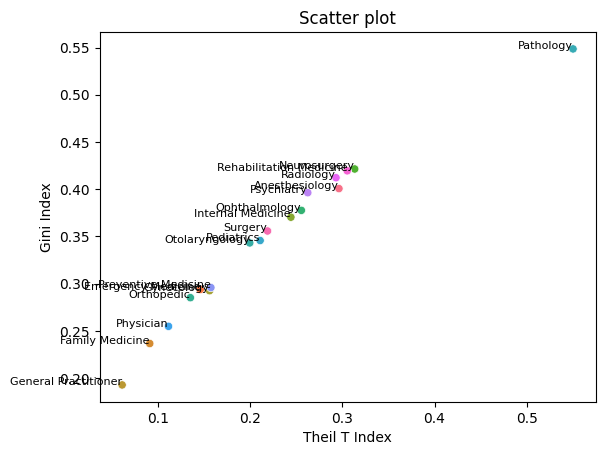

In [134]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot
sns.scatterplot(x='T_prov', y='G_prov', hue='spc', data=result_ineq, color='blue')

for i, row in result_ineq.iterrows():
    plt.text(row['T_prov'], row['G_prov'], row['spc'], fontsize=8, ha='right')

# Set labels and title
plt.xlabel('Theil T Index')
plt.ylabel('Gini Index')
plt.title(f'Scatter plot')

# Remove legend
plt.legend().set_visible(False)

# Show the plot
plt.show()

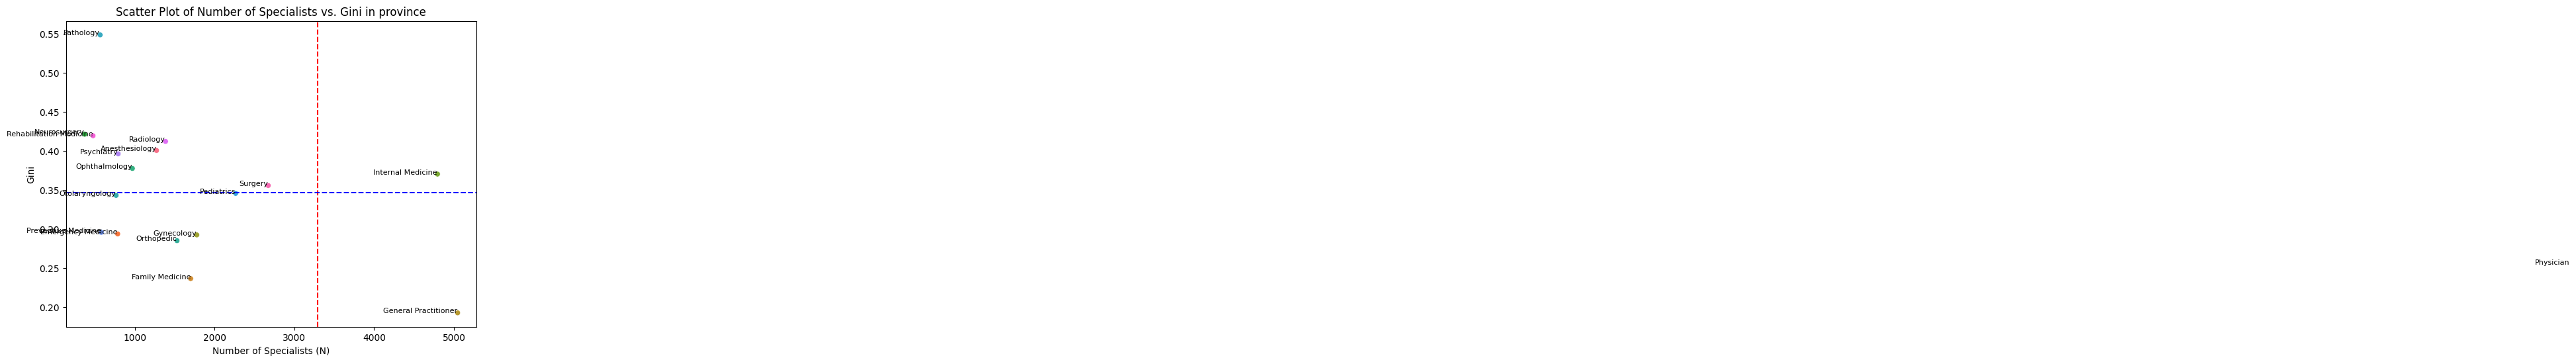

In [136]:
plt.figure(figsize=(8, 6))  # Adjust the figsize to a smaller value

# Scatter plot
sns.scatterplot(x='n_spc', y='G_prov', hue='spc', data=result_ineq[result_ineq['spc'] != 'Physician'], color='blue')

for i, row in result_ineq.iterrows():
    plt.text(row['n_spc'], row['G_prov'], row['spc'], fontsize=8, ha='right')

plt.axvline(np.mean(result_ineq['n_spc']), color='red', linestyle='--')
plt.axhline(np.mean(result_ineq['G_prov']), color='blue', linestyle='--')

plt.title(f'Scatter Plot of Number of Specialists vs. Gini in province')
plt.xlabel('Number of Specialists (N)')
plt.ylabel('Gini')
plt.legend().set_visible(False)
plt.show()  

Analyse Logitudinal

In [139]:
df = spc_df[spc_df['year'] >= 2015]
df = pd.merge(df, hosp[['hcode', 'prov', 'dist_id', 'hregion', 'type']], how='left', left_on='hosp_id', right_on='hcode')
df['dist_id'] = df['dist_id'].astype(int).astype(str)
df['type_gr'] = df['type'].apply(lambda x: 'private' if x == 'โรงพยาบาลเอกชน' else 'public')

df_public = df[df['type_gr'] == 'public']

# Region level
df_hregion = df_public.pivot_table(index=['year', 'hregion', 'spc'], values='total', aggfunc='sum', fill_value=0).reset_index()
df_hregion = pd.merge(df_hregion, pop_hregion[['hregion', 'pop']], how='left', on='hregion')
df_hregion['den'] = df_hregion['total']/(df_hregion['pop']/1000)
df_hregion.to_csv('output/analyse/spc_hregion_year.csv')

# Province level
df_prov = df_public.pivot_table(index=['year', 'prov', 'spc'], values='total', aggfunc='sum', fill_value=0).reset_index()
df_prov = pd.merge(df_prov, pop_prov[['prov', 'pop']], how='left', on='prov')
df_prov['den'] = df_prov['total']/(df_prov['pop']/1000)
df_prov.to_csv('output/analyse/spc_prov_year.csv')

# District level
df_dist = df_public.pivot_table(index=['year', 'dist_id', 'spc'], values='total', aggfunc='sum', fill_value=0).reset_index()
df_dist = pd.merge(df_dist, pop_dist[['dist_id', 'pop']], how='left', on='dist_id')
df_dist['den'] = df_dist['total']/(df_dist['pop']/1000)
df_dist.to_csv('output/analyse/spc_dist_year.csv')

df_hregion, df_prov, df_dist

(      year         hregion                      spc  total      pop       den
 0     2015  เขตสุขภาพที่ 1           Anesthesiology   75.0  5850954  0.012818
 1     2015  เขตสุขภาพที่ 1       Emergency Medicine   26.0  5850954  0.004444
 2     2015  เขตสุขภาพที่ 1          Family Medicine   86.0  5850954  0.014698
 3     2015  เขตสุขภาพที่ 1     General Practitioner  221.0  5850954  0.037772
 4     2015  เขตสุขภาพที่ 1               Gynecology  116.0  5850954  0.019826
 ...    ...             ...                      ...    ...      ...       ...
 2335  2024  เขตสุขภาพที่ 9      Preventive Medicine   67.0  6680244  0.010030
 2336  2024  เขตสุขภาพที่ 9               Psychiatry   40.0  6680244  0.005988
 2337  2024  เขตสุขภาพที่ 9                Radiology   88.0  6680244  0.013173
 2338  2024  เขตสุขภาพที่ 9  Rehabilitation Medicine   26.0  6680244  0.003892
 2339  2024  เขตสุขภาพที่ 9                  Surgery  172.0  6680244  0.025748
 
 [2340 rows x 6 columns],
        year        prov